<a href="https://colab.research.google.com/github/BanceSt/StageRN/blob/master/catsVsDogs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/dataStage/audio-cats-and-dogs.zip" -d /content/sample_data

Archive:  /content/drive/My Drive/dataStage/audio-cats-and-dogs.zip
  inflating: /content/sample_data/cats_dogs/cat_1.wav  
  inflating: /content/sample_data/cats_dogs/cat_10.wav  
  inflating: /content/sample_data/cats_dogs/cat_100.wav  
  inflating: /content/sample_data/cats_dogs/cat_101.wav  
  inflating: /content/sample_data/cats_dogs/cat_102.wav  
  inflating: /content/sample_data/cats_dogs/cat_103.wav  
  inflating: /content/sample_data/cats_dogs/cat_105.wav  
  inflating: /content/sample_data/cats_dogs/cat_106.wav  
  inflating: /content/sample_data/cats_dogs/cat_107.wav  
  inflating: /content/sample_data/cats_dogs/cat_108.wav  
  inflating: /content/sample_data/cats_dogs/cat_109.wav  
  inflating: /content/sample_data/cats_dogs/cat_11.wav  
  inflating: /content/sample_data/cats_dogs/cat_110.wav  
  inflating: /content/sample_data/cats_dogs/cat_112.wav  
  inflating: /content/sample_data/cats_dogs/cat_113.wav  
  inflating: /content/sample_data/cats_dogs/cat_114.wav  
  inflat

In [98]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from matplotlib.image import imread
from tensorflow import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import scipy.io.wavfile as wavfile
import sklearn
import sklearn.metrics
import seaborn as sns
import random
import math
import sklearn.utils
import sklearn.metrics
import matplotlib.pyplot as plt
import glob
import os
import scipy
import scipy.signal
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
import IPython

print(tf.version.VERSION)


1.15.0


In [0]:
WAVE_FOLDER = '/content/sample_data/cats_dogs'
FRAMERATE = 16000
MAX_WAV_SAMPLES = 20*FRAMERATE
DOWNSAMPLING_SCALE = 1

df = pd.read_csv("/content/sample_data/train_test_split.csv")
test_cat = df[['test_cat']].dropna().rename(index=str, columns={"test_cat": "file"}).assign(label=0)
test_dog = df[['test_dog']].dropna().rename(index=str, columns={"test_dog": "file"}).assign(label=1)
train_cat = df[['train_cat']].dropna().rename(index=str, columns={"train_cat": "file"}).assign(label=0)
train_dog = df[['train_dog']].dropna().rename(index=str, columns={"train_dog": "file"}).assign(label=1)

test_df = pd.concat([test_cat, test_dog]).reset_index(drop=True)
train_df = pd.concat([train_cat, train_dog]).reset_index(drop=True)

**Fonction pour créer un spectrogramme, avec exemple :**


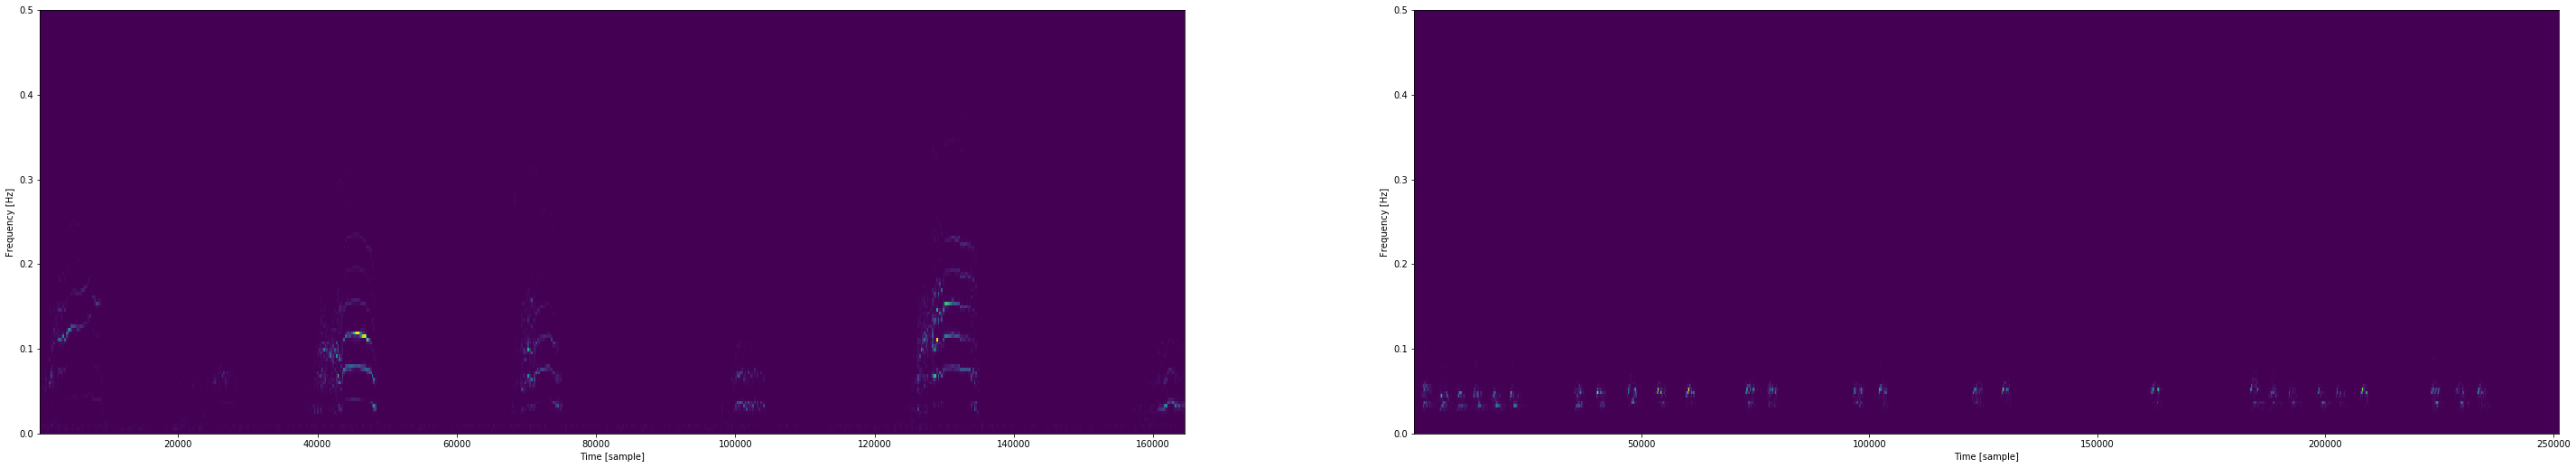

In [0]:
def plot_spectrogram(file):
    x = wavfile.read(file)[1]
    f, t, Sxx = scipy.signal.spectrogram(x)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sample]')


plt.figure(figsize=(50,50))
for i in range(0,2,2):
    plt.subplot(5,2,i+1)
    plot_spectrogram(os.path.join(WAVE_FOLDER, test_cat.iloc[i]['file']))
    plt.subplot(5,2,i+2)
    plot_spectrogram(os.path.join(WAVE_FOLDER, test_dog.iloc[i]['file']))

**Fonction pour sauvegarder les spectres, de tous un dossier de son :**

In [0]:
def save_all_spectro(base ,path) :
  fig = plt.figure()
  for i in range(len(base)) :
    img = base.iloc[i]["file"][:-3] + "png"
    plt.axis("off")
    plot_spectrogram(os.path.join("/content/sample_data/cats_dogs", base.iloc[i]["file"]))
    fig.savefig(path + img,bbox_inches='tight',transparent=True, pad_inches=0)
    plt.clf()
"""

plt.axis('off')
plot_spectrogram(os.path.join(WAVE_FOLDER, test_cat.iloc[0]['file']))
fig.savefig("/content/drive/My Drive/dataStage/cat_spec_0.png",bbox_inches='tight',transparent=True, pad_inches=0)
plt.clf()
plt.axis('off')
plot_spectrogram(os.path.join(WAVE_FOLDER, test_dog.iloc[0]['file']))
fig.savefig("/content/drive/My Drive/dataStage/dog_spec_0.png",bbox_inches='tight',transparent=True, pad_inches=0)"""


'\n\nplt.axis(\'off\')\nplot_spectrogram(os.path.join(WAVE_FOLDER, test_cat.iloc[0][\'file\']))\nfig.savefig("/content/drive/My Drive/dataStage/cat_spec_0.png",bbox_inches=\'tight\',transparent=True, pad_inches=0)\nplt.clf()\nplt.axis(\'off\')\nplot_spectrogram(os.path.join(WAVE_FOLDER, test_dog.iloc[0][\'file\']))\nfig.savefig("/content/drive/My Drive/dataStage/dog_spec_0.png",bbox_inches=\'tight\',transparent=True, pad_inches=0)'

**Création des fichiers contenant les spectres :**

In [0]:
try :
  os.makedirs("/content/sample_data/cats_dogs_spec")
  os.makedirs("/content/sample_data/cats_dogs_spec/test")
  os.makedirs("/content/sample_data/cats_dogs_spec/test/cats")
  os.makedirs("/content/sample_data/cats_dogs_spec/test/dogs")
  os.makedirs("/content/sample_data/cats_dogs_spec/train/cats")
  os.makedirs("/content/sample_data/cats_dogs_spec/train/dogs")
except OSError:
  pass 

**Sauvegarde des spectres :**

In [0]:
save_all_spectro(train_cat, "/content/sample_data/cats_dogs_spec/train/cats/")
save_all_spectro(train_dog, "/content/sample_data/cats_dogs_spec/train/dogs/")
save_all_spectro(test_cat, "/content/sample_data/cats_dogs_spec/test/cats/")
save_all_spectro(test_dog, "/content/sample_data/cats_dogs_spec/test/dogs/")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

**Partie qui servira à equilibre le nombre de cris de chats et de chiens**

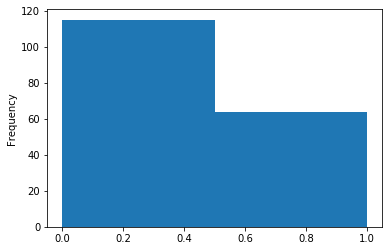

In [0]:
#Histogramme du nombre de cris par type d'animaux (chat, chien)
train_df['label'].plot.hist(bins=2)

In [0]:
#Equilibrage des nombres de cris dans train_files, train_labels
random_oversampler = RandomOverSampler()
idx = np.arange(0, len(train_df)).reshape(-1, 1)
idx_sampled, _ = random_oversampler.fit_sample(idx, train_df['label'])
train_files, train_labels = train_df.iloc[idx_sampled.flatten()]['file'].values, train_df.iloc[idx_sampled.flatten()]['label'].values
train_files, train_labels = sklearn.utils.shuffle(train_files, train_labels)
test_files, test_labels = test_df['file'].values, test_df['label'].values



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
train_files_spec = []
test_files_spec = []
for i in range(len(train_files)) :
  train_files_spec.append(train_files[i].replace("wav","png"))
for i in range(len(test_files)) :
  test_files_spec.append(test_files[i].replace("wav","png"))


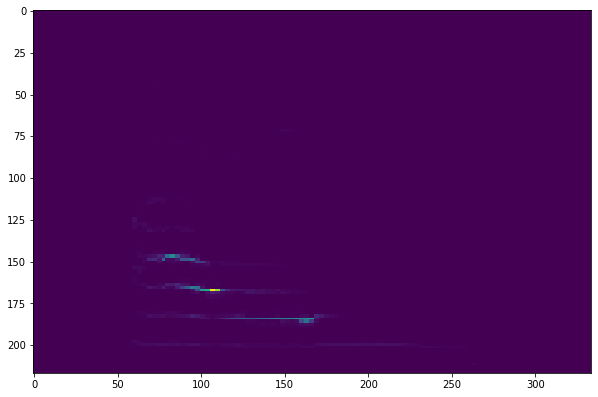

In [0]:
img = imread("/content/sample_data/cats_dogs_spec/train/cats/" + train_files_spec[24])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [0]:
for i in range(len(train_files_spec)) :
  if "dog" in train_files_spec[i] :
    train_files_spec[i] = imread("/content/sample_data/cats_dogs_spec/train/dogs/" + train_files_spec[i])
  else :
    train_files_spec[i] = imread("/content/sample_data/cats_dogs_spec/train/cats/" + train_files_spec[i])

  

for i in range(len(test_files_spec)) :
  if "cat" in test_files_spec[i] :
    test_files_spec[i] = imread("/content/sample_data/cats_dogs_spec/test/cats/" + test_files_spec[i])
  else :
    test_files_spec[i] = imread("/content/sample_data/cats_dogs_spec/test/dogs/" + test_files_spec[i])

In [0]:
train_files_spec = np.asarray(train_files_spec)
print(train_files_spec.shape)
test_files_spec = np.asarray(test_files_spec)
print(test_files_spec.shape)
train_files_spec = train_files_spec/255.0
test_files_spec = test_files_spec/255.0


(230, 217, 334, 4)
(98, 217, 334, 4)
(230, 217, 334, 4)


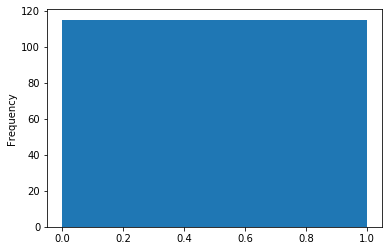

In [0]:
#Historigramme après équilibrage
pd.Series(train_labels).plot.hist(bins=2);

**Générateur qui seront utiliser sur le model**

In [0]:
#Génére des batch, et des labels pour l'apprentissage
def fit_generator(train_files, train_labels, wavs_per_batch=20, augments=5):
    while True:
        maxidx = len(train_files)
        for i in range(0, maxidx, wavs_per_batch):
            waves_batch = []
            labels_batch = []
            for j in range(i, min(maxidx, i+wavs_per_batch)):
                file, label = train_files[j], train_labels[j]
                wave_raw = wavfile.read(os.path.join(WAVE_FOLDER, file))[1]
                wave_raw = wave_raw/np.std(wave_raw)
                length = len(wave_raw)
                waves_batch.append(np.pad(wave_raw, pad_width=((0, MAX_WAV_SAMPLES - length)), mode='wrap'))
                labels_batch.append(label)
                for _ in range(augments):
                    wave_rotated = np.roll(wave_raw, random.randint(0, length))
                    while random.choice([True, False]):
                        wave_rotated += np.roll(wave_raw, random.randint(0, length))
                    wave = np.pad(wave_rotated, pad_width=((0, MAX_WAV_SAMPLES - length)), mode='wrap')
                    #wave = scipy.signal.decimate(wave, DOWNSAMPLING_SCALE)
                    waves_batch.append(wave)
                    labels_batch.append(label)
            yield np.array(waves_batch), np.array(labels_batch)



In [0]:
#Génére des batch, et des labels pour la validation
def validate_generator(test_files, test_labels, wavs_per_batch=20):
    while True:
        maxidx = len(test_files)
        for i in range(0, maxidx, wavs_per_batch):
            waves_batch = []
            labels_batch = []
            for j in range(i, min(maxidx, i+wavs_per_batch)):
                file, label = test_files[j], test_labels[j]
                wave_raw = wavfile.read(os.path.join(WAVE_FOLDER, file))[1]
                wave_raw = wave_raw/np.std(wave_raw)
                length = len(wave_raw)
                left = 0
                right = MAX_WAV_SAMPLES - left - length
                wave = np.pad(wave_raw, pad_width=((left, right)), mode='wrap')
                #wave = scipy.signal.decimate(wave, DOWNSAMPLING_SCALE)
                waves_batch.append(wave)
                labels_batch.append(label)
            yield np.array(waves_batch), np.array(labels_batch)

In [0]:
def steps_per_epoch(wavs_per_epoch, wavs_per_batch):
    return int(math.ceil(wavs_per_epoch/wavs_per_batch))

In [0]:
checkpoint_path = "/content/drive/My Drive/savemodel/Model15chk/cp-{epoch:04d}"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

print(checkpoint_dir)

/content/drive/My Drive/savemodel/Model15chk


In [0]:
#Création du model
def create_model() :
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Reshape((MAX_WAV_SAMPLES//DOWNSAMPLING_SCALE,1), input_shape=(MAX_WAV_SAMPLES//DOWNSAMPLING_SCALE,)))
  for i in range(14):
    model.add(tf.keras.layers.Conv1D(32, kernel_size=5, 
                                     padding='same',
                                     activation='relu',
                                     kernel_initializer=tf.keras.initializers.Orthogonal(),
                                     ))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
  return model
  
model = create_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [97]:
def create_model_spec() :
  model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(217, 334 ,4)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
  return model

model2 = create_model_spec()

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
WAVS_PER_BATCH = 3
AUGMENTS = 10
EPOCHS=15

In [0]:
batch_size = 20
epochs = 15
IMG_HEIGHT = 217
IMG_WIDTH = 334
total_train = 230
total_val = 98

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [112]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory="/content/sample_data/cats_dogs_spec/train",
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')



Found 179 images belonging to 2 classes.


In [113]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory="/content/sample_data/cats_dogs_spec/test",
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 98 images belonging to 2 classes.


In [114]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15


ValueError: ignored

In [0]:
#Apprentissage

model.save_weights(checkpoint_path.format(epoch=0))
model.fit_generator(fit_generator(train_files, train_labels, WAVS_PER_BATCH, AUGMENTS),
                    steps_per_epoch=steps_per_epoch(len(train_files), WAVS_PER_BATCH),
                    epochs = EPOCHS,
                    validation_data=validate_generator(test_files, test_labels, WAVS_PER_BATCH),
                    validation_steps=steps_per_epoch(len(test_files), WAVS_PER_BATCH),
                    callbacks = [cp_callback],
                    verbose=2)

Epoch 1/15
Epoch 1/15

Epoch 00001: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0001
77/77 - 39s - loss: 0.7455 - acc: 0.6763 - val_loss: 0.7020 - val_acc: 0.5000
Epoch 2/15
Epoch 1/15

Epoch 00002: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0002
77/77 - 30s - loss: 0.6178 - acc: 0.7170 - val_loss: 0.6319 - val_acc: 0.5510
Epoch 3/15
Epoch 1/15

Epoch 00003: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0003
77/77 - 30s - loss: 0.5239 - acc: 0.7636 - val_loss: 0.3632 - val_acc: 0.8673
Epoch 4/15
Epoch 1/15

Epoch 00004: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0004
77/77 - 30s - loss: 0.4932 - acc: 0.7818 - val_loss: 0.2810 - val_acc: 0.9286
Epoch 5/15
Epoch 1/15

Epoch 00005: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0005
77/77 - 30s - loss: 0.4485 - acc: 0.7980 - val_loss: 0.2195 - val_acc: 0.9388
Epoch 6/15
Epoch 1/15

Epoch 00006: saving model to /content/drive/My Drive/savemodel

0.5


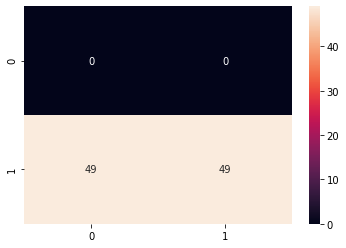

In [0]:
#Matrice de confusion
def matrice_confusion(modele) :
  predicted_probs = modele.predict_generator(
      validate_generator(test_files, test_labels, WAVS_PER_BATCH),
      steps=steps_per_epoch(len(test_files), WAVS_PER_BATCH))
  predicted_classes = np.argmax(predicted_probs, axis=1)
  print(sklearn.metrics.accuracy_score(predicted_classes, test_labels))
  sns.heatmap(sklearn.metrics.confusion_matrix(predicted_classes, test_labels), annot=True);

matrice_confusion(model)

In [0]:

# test sur un wav particulier
aFile = "/content/sample_data/cats_dogs/test/cats/cat_110.wav"

wave_raw = wavfile.read(aFile)[1]
wave_raw = wave_raw/np.std(wave_raw)
length = len(wave_raw)
left = 0
right = MAX_WAV_SAMPLES - left - length
wave = np.pad(wave_raw, pad_width=((left, right)), mode='wrap')



In [0]:
wave = wave.reshape( (1,wave.size) )

resu = model.predict(wave)
print(resu)

[[9.9979645e-01 2.0354726e-04]]


In [0]:
# test sur un wav particulier
files = ["/content/sample_data/cats_dogs/test/cats/cat_110.wav","/content/sample_data/cats_dogs/train/dog/dog_barking_10.wav"]

waves = []
for aFile in files:
  
  wave_raw = wavfile.read(aFile)[1]
  wave_raw = wave_raw/np.std(wave_raw)
  length = len(wave_raw)
  left = 0
  right = MAX_WAV_SAMPLES - left - length
  wave = np.pad(wave_raw, pad_width=((left, right)), mode='wrap')
  wave = wave.reshape( (1,wave.size) )
  print(wave.shape)

  if len(waves) == 0 :
    waves = wave
  else :
    waves = np.concatenate((waves, wave), axis = 0)


(1, 320000)
(1, 320000)


In [0]:
print(waves.shape)

(2, 320000)


In [0]:
resu = model.predict(waves)
print(resu)

[[0.99579704 0.00420293]
 [0.72803724 0.27196282]]


In [0]:
valeur = "/content/drive/My Drive/savemodel/Model15chk"
!ls "$valeur"


checkpoint		     cp-0008.data-00001-of-00002
cp-0001.data-00000-of-00002  cp-0008.index
cp-0001.data-00001-of-00002  cp-0009.data-00000-of-00002
cp-0001.index		     cp-0009.data-00001-of-00002
cp-0002.data-00000-of-00002  cp-0009.index
cp-0002.data-00001-of-00002  cp-0010.data-00000-of-00002
cp-0002.index		     cp-0010.data-00001-of-00002
cp-0003.data-00000-of-00002  cp-0010.index
cp-0003.data-00001-of-00002  cp-0011.data-00000-of-00002
cp-0003.index		     cp-0011.data-00001-of-00002
cp-0004.data-00000-of-00002  cp-0011.index
cp-0004.data-00001-of-00002  cp-0012.data-00000-of-00002
cp-0004.index		     cp-0012.data-00001-of-00002
cp-0005.data-00000-of-00002  cp-0012.index
cp-0005.data-00001-of-00002  cp-0013.data-00000-of-00002
cp-0005.index		     cp-0013.data-00001-of-00002
cp-0006.data-00000-of-00002  cp-0013.index
cp-0006.data-00001-of-00002  cp-0014.data-00000-of-00002
cp-0006.index		     cp-0014.data-00001-of-00002
cp-0007.data-00000-of-00002  cp-0014.index
cp-0007.data-00001-of-00

In [0]:
chaine="toto"
!echo "truc$chaine"

tructoto


In [0]:
model1 = create_model()
model1.load_weights(checkpoint_path.format(epoch=10))

0.9489795918367347


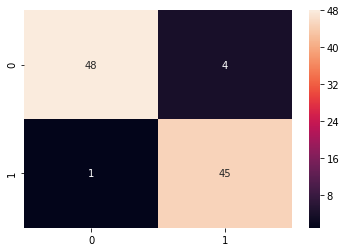

In [0]:
#Matrice de confusion
matrice_confusion(model1)